## III.3 An Improved SPINN Framework for Material Characterization

In [2]:
# Visualization of the analytical solution
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
import numpy as np

import phd.models.cm.analytical_plate as ap
from phd.config import load_config, copy_config, apply_overrides
from phd.plot.plot_cm import plot_field

from phd.plot import get_current_config as plt_cfg, book_config, book_compact_config, A4_config
book_config.set_as_current()
page_width = plt_cfg().page_width
# Configuration
save_fig = True
save_table = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## Forward Problem
We benchmark different implementations (PINN/SPINN with mixed/displacement formulation)

In [5]:
# === Forward Problem: SPINN/PINN × mixed/displacement ===

# Run configurations to train (empty list = load all from disk)
configs_to_run = []  # e.g. ["spinn_mixed", "spinn_disp", "pinn_mixed", "pinn_disp"]

# Load base config
base_cfg = load_config("analytical_plate")
base_cfg.task.type = "forward"
base_cfg.seed = 0

# Define model variants (only the differences from base)
model_variants = {
    "spinn_mixed": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
}

all_config_names = list(model_variants.keys())
results_forward = {}

# Text labels for plotting
config_text_dict = {
    "spinn_mixed": "SPINN (mixed)",
    "spinn_disp": "SPINN (disp.)",
    "pinn_mixed": "PINN (mixed)",
    "pinn_disp": "PINN (disp.)",
}

# === Train or Load each configuration ===
for config_name in all_config_names:
    run_name = config_name
    should_train = config_name in configs_to_run
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg)
        apply_overrides(cfg, model_variants[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model that is not serializable)
        results.pop("model", None)
        results_forward[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_forward[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed
Loading: spinn_disp
Loading: pinn_mixed
Loading: pinn_disp


### Table of the results

In [3]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history
from phd.io import save_df_to_latex

def build_results_df(all_data, config_text_dict=None, append_config=False):
    """Build a summary DataFrame from all_data dict."""
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        raw_runtime_metrics = entry.get("runtime_metrics", {})
        runtime_metrics = {}
        runtime_metrics["Time [m]"] = raw_runtime_metrics["elapsed_time"]/60
        runtime_metrics["Iter./s"] =raw_runtime_metrics["iterations_per_sec"]
        runtime_metrics["# Params"] = raw_runtime_metrics["net_params_count"]
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get formulation from config
        config = entry.get("config", {})
        # formulation = config.get("model", {}).get("formulation", "mixed")

        table_cfg = config if append_config else {}
        rows.append({
            "Model": name,
            # "formulation": formulation,
            **final_metrics,
            **runtime_metrics,
            **table_cfg,
        })            

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
df_results = build_results_df(results_forward, config_text_dict=config_text_dict)
display(
    df_results.style
    .background_gradient(subset=["L2 Error"], cmap="Greens_r")
    .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "Stress BC Loss", "Total Loss"])
    .format("{:.2f}", subset=["Time [m]", "Iter./s"])
    .format("{:.0f}", subset=["# Params"])
    .set_properties(subset=["Model"], **{"text-align": "left"})
)

# Save results table
if save_table:
    df_to_save = df_results[['Model', 'L2 Error', 'Total Loss', 'Time [m]', 'Iter./s', '# Params']]
    formatters = {
        "L2 Error": "{:.2e}",
        "Total Loss": "{:.2e}",
        "Time [m]": "{:.2f}",
        "Iter./s": "{:.2f}",
        "# Params": "{:.0f}",
    }
    save_df_to_latex(df_to_save, "./tables/spinn_ap_forward_results.tex", formatters=formatters)

,Model,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,Time [m],Iter./s,# Params
0,PINN (disp.),2.10e-03,9.21e-04,nan,4.64e-04,5.47e-04,4.93,203.00,6234
1,SPINN (mixed),3.08e-03,5.18e-04,1.80e-04,nan,5.67e-04,1.30,767.58,12800
2,SPINN (disp.),4.98e-03,6.21e-03,nan,1.94e-03,2.72e-03,3.49,286.40,6464
3,PINN (mixed),4.99e-03,7.66e-04,3.51e-04,nan,9.23e-04,2.53,395.14,14045


Saved LaTeX table to tables/spinn_ap_forward_results.tex


Saved: './images/ap_forward_comparaison.png'


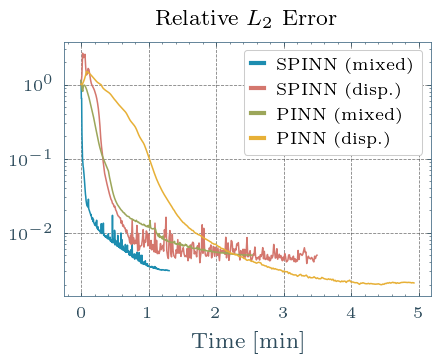

In [9]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

page_width = plt_cfg().page_width
# Plotting L2 Error for all runs
if results_forward:
    fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.35), dpi=200)
    plt_config = plt_cfg()
    plt_config.min_font_size = plt_config.axes_font_size
    plt_config.set_as_current()
    plot_metrics_comparison(
        results_forward, metric_name="L2 Error", 
        run_names=[config_text_dict.get(k, k) for k in results_forward.keys()],
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"Relative $L_2$ Error")
    book_config.set_as_current()
    if save_fig:
        
        os.makedirs('./images/pgf', exist_ok=True)
        fig.savefig('./images/pgf/ap_forward_comparaison.pgf', bbox_inches='tight')
        fig.savefig('./images/ap_forward_comparaison.png', dpi=300, bbox_inches='tight')
        print(f"Saved: './images/ap_forward_comparaison.png'")

## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [3]:
# === Inverse Problem: SPINN/PINN × mixed/displacement + PINN enhanced ===
from phd.config import apply_overrides

# Run configurations to train (empty list = load all from disk)
configs_to_run_inverse = [] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]

# Load base config
base_cfg_inverse = load_config("analytical_plate")
base_cfg_inverse.task.type = "inverse"
base_cfg_inverse.training.n_iter = 60000
base_cfg_inverse.training.log_every = 200
base_cfg_inverse.seed = 0

# Define model variants (only the differences from base)
model_variants_inverse = {
    "spinn_mixed_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "mixed",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5]
    },
    "spinn_disp_inv": {
        "model.net_type": "SPINN",
        "model.formulation": "displacement",
        "model.architecture.width": 32,
        "model.architecture.rank": 32,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_mixed_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "model.architecture.width": 36,
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],

    },
    "pinn_disp_inv": {
        "model.net_type": "PINN",
        "model.formulation": "displacement",
        "model.architecture.width": 36,
        "training.lr": 1e-4,  # 10x lower for displacement
        "training.lr_decay": ["warmup cosine", 1e-4, 1e-4, 20000, 60000, 1e-6],
    },
    "pinn_enhanced_inv": {
        "model.net_type": "PINN",
        "model.formulation": "mixed",
        "training.lr_decay": ["warmup cosine", 1e-3, 1e-3, 20000, 60000, 1e-5],
        "model.architecture.width": 36,
        "task.inverse.training_factors.lmbd": 0.05,
        "task.inverse.training_factors.mu": 0.05,
    },
}

all_config_names_inverse = list(model_variants_inverse.keys())
results_inverse = {}

# Text labels for plotting
config_text_dict_inverse = {
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (displacement)",
    "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (displacement)",
    "pinn_enhanced_inv": "PINN (enhanced)",
}

# === Train or Load each configuration ===
for config_name in all_config_names_inverse:
    run_name = config_name
    should_train = config_name in configs_to_run_inverse
    
    if should_train:
        # Create a fresh copy and apply variant settings
        cfg = copy_config(base_cfg_inverse)
        apply_overrides(cfg, model_variants_inverse[config_name])
        
        print(f"Training: {run_name}")
        results = ap.train(cfg)
        
        # Save using problem-specific wrapper
        ap.save_run_data(results, run_name=run_name)
        
        # Store in memory (excluding model for memory efficiency)
        results.pop("model", None)
        results_inverse[run_name] = results
    else:
        # Load existing run
        try:
            print(f"Loading: {run_name}")
            results_inverse[run_name] = ap.load_run(run_name)
        except FileNotFoundError:
            print(f"Warning: {run_name} not found")

Loading: spinn_mixed_inv


W0202 10:48:26.758609   32237 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0202 10:48:26.763870   31806 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


Loading: spinn_disp_inv
Loading: pinn_mixed_inv
Loading: pinn_disp_inv
Loading: pinn_enhanced_inv


In [3]:
# === Results Summary ===
import pandas as pd
from IPython.display import display
from phd.plot.plot_cm import compute_metrics_from_history

def build_inverse_results_df(all_data, config_text_dict=None):
    """Build a summary DataFrame from inverse results."""
    rows = [

    ]
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        
        # Get L2 error from losshistory metrics
        losshistory = entry.get("losshistory")
        runtime_metrics = entry.get("runtime_metrics", {}).copy()
        config = entry.get("config", {})
        if losshistory:
            metrics = compute_metrics_from_history(losshistory, config)
            get_final = lambda v: v[-1] if v is not None else None
            final_metrics = {k: get_final(v) for k, v in metrics.items() if k != "steps"}
        
        runtime_metrics["elapsed_time"] /= 60 # convert to minutes
        name = config_text_dict.get(key, key) if config_text_dict is not None else key
        
        # Get material parameter discovery from variable callback
        var_cb = entry.get("callbacks", {}).get("variable_value", None)
        final_lmbd = np.nan
        final_mu = np.nan
        if var_cb and var_cb.history:
            var_hist = np.array(var_cb.history)
            final_lmbd = var_hist[-1, 1]  # Last value of lambda
            final_mu = var_hist[-1, 2]    # Last value of mu

        rows.append({
            "Model": name,
            **final_metrics,
            "final_λ": final_lmbd,
            "final_μ": final_mu,
            **runtime_metrics,
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("L2 Error", ascending=True).reset_index(drop=True)
    return df

# Build and display results DataFrame
if results_inverse:
    df_results_inv = build_inverse_results_df(results_inverse, config_text_dict=config_text_dict_inverse)
    display(
        df_results_inv.style
        .background_gradient(subset=["L2 Error"], cmap="Greens_r")
        .format("{:.2e}", subset=["L2 Error","PDE Loss", "Material Loss", "DIC Loss","Total Loss"])
        .format("{:.4f}", subset=["final_λ", "final_μ"])
        .format("{:.2f}", subset=["iterations_per_sec", "elapsed_time"])
        .format("{:.0f}", subset=["net_params_count"])
        .set_properties(subset=["Model"], **{"text-align": "left"})
    )
else:
    print("No results loaded. Set configs_to_run_inverse or ensure saved runs exist.")

,Model,L2 Error,PDE Loss,Material Loss,Stress BC Loss,Total Loss,DIC Loss,final_λ,final_μ,elapsed_time,iterations_per_sec,net_params_count
0,SPINN (mixed),4.10e-03,4.35e-04,2.84e-04,nan,5.03e-04,4.92e-07,1.0022,0.4995,3.29,303.79,12800
1,SPINN (displacement),4.08e-02,1.16e-02,nan,0.005015,5.89e-03,2.33e-04,0.9563,0.5474,4.66,214.73,6464
2,PINN (enhanced),6.08e-02,8.19e-04,2.80e-04,nan,4.46e-03,2.83e-04,0.8373,0.5540,4.06,246.28,14045
3,PINN (displacement),6.57e-02,1.29e-03,nan,0.005480,4.92e-03,6.53e-04,0.8798,0.6000,5.24,190.66,5618
4,PINN (mixed),1.38e+00,1.02e-03,7.82e-04,nan,9.74e-02,1.77e-02,-2.1231,1.9499,3.80,262.84,11205


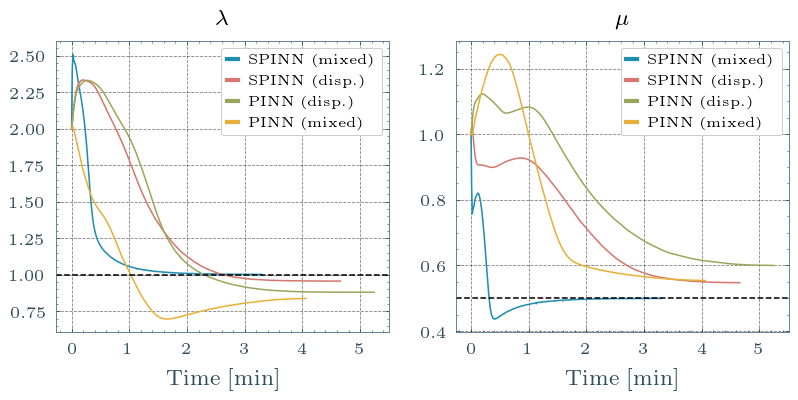

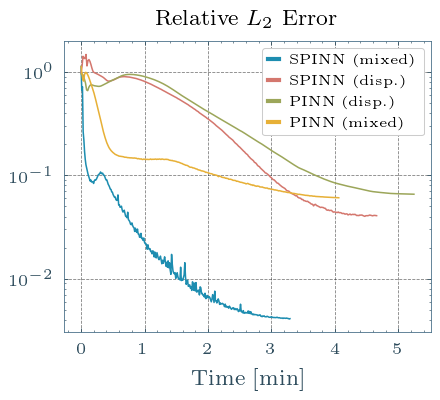

In [6]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

config_text_inv ={
    "spinn_mixed_inv": "SPINN (mixed)",
    "spinn_disp_inv": "SPINN (disp.)",
    # "pinn_mixed_inv": "PINN (mixed)",
    "pinn_disp_inv": "PINN (disp.)",
    "pinn_enhanced_inv": "PINN (mixed)",
}

# Create figure with 3 subplots
page_width = plt_cfg().page_width
fig, axes = plt.subplots(1, 2, figsize=(page_width, page_width * 0.4), dpi=200)
ax_lmbd, ax_mu = axes



configs_to_plot = ["spinn_mixed_inv", "spinn_disp_inv", "pinn_disp_inv", "pinn_enhanced_inv"] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]
# Use available results
if results_inverse:
    results_to_plot = {k: results_inverse[k] for k in configs_to_plot if k in results_inverse}
    run_names_inv = [config_text_inv.get(k, k) for k in results_to_plot.keys()]

    # Plot Lambda
    plot_metrics_comparison(
        results_to_plot, metric_name="lambda", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_lmbd, ylabel=''
    )
    lmbd_true = results_to_plot["spinn_mixed_inv"]["config"]["problem"]["material"]["lmbd"]
    ax_lmbd.axhline(y=lmbd_true, linestyle='--', color='k', label="True")
    ax_lmbd.set_title(r"$\lambda$")

    # Plot Mu
    plot_metrics_comparison(
        results_to_plot, metric_name="mu", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_mu, ylabel=''
    )
    mu_true = results_to_plot["spinn_mixed_inv"]["config"]["problem"]["material"]["mu"]
    ax_mu.axhline(y=mu_true, linestyle='--', color='k', label="True")
    ax_mu.set_title(r"$\mu$")
    # ax_mu.legend()

    fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.4), dpi=200)

    plot_metrics_comparison(
        results_to_plot, metric_name="L2 Error", run_names=run_names_inv,
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"Relative $L_2$ Error")

Saved: './images/ap_inverse_comparaison.png'


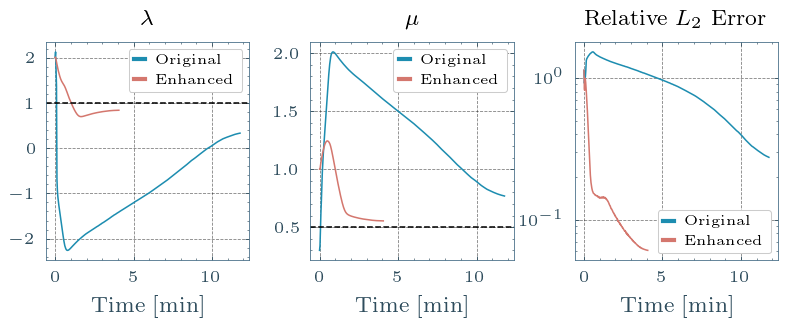

In [ ]:
# === Compare Metrics for multiple runs ===
from phd.plot.plot_cm import plot_metrics_comparison

results_inverse["pinn_200k"] = ap.load_run("PINN_inverse_200k")

config_text_inv ={
    "pinn_enhanced_inv": "Enhanced",
    "pinn_200k": "Original",
}

# Create figure with 3 subplots
page_width = plt_cfg().page_width
fig, axes = plt.subplots(1, 3, figsize=(page_width, page_width * 0.3), dpi=200, gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
ax_lmbd, ax_mu, ax_l2 = axes

# plt_config = plt_cfg()
# plt_config.min_font_size = plt_config.axes_font_size
# plt_config.set_as_current()

configs_to_plot = ["pinn_200k", "pinn_enhanced_inv"] # e.g. ["spinn_mixed_inv", "spinn_disp_inv", "pinn_mixed_inv", "pinn_disp_inv", "pinn_enhanced_inv"]
# Use available results
if results_inverse:
    results_to_plot = {k: results_inverse[k] for k in configs_to_plot if k in results_inverse}
    run_names_inv = [config_text_inv.get(k, k) for k in results_to_plot.keys()]

    # Plot Lambda
    plot_metrics_comparison(
        results_to_plot, metric_name="lambda", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_lmbd, ylabel=''
    )
    lmbd_true = list(results_to_plot.values())[0]["config"]["problem"]["material"]["lmbd"]
    ax_lmbd.axhline(y=lmbd_true, linestyle='--', color='k', label="True")
    ax_lmbd.set_title(r"$\lambda$")

    # Plot Mu
    plot_metrics_comparison(
        results_to_plot, metric_name="mu", run_names=run_names_inv,
        step_type="time", time_unit="min", ax=ax_mu, ylabel=''
    )
    mu_true = list(results_to_plot.values())[0]["config"]["problem"]["material"]["mu"]
    ax_mu.axhline(y=mu_true, linestyle='--', color='k', label="True")
    ax_mu.set_title(r"$\mu$")
    # ax_mu.legend()

    # fig, ax_l2 = plt.subplots(1, 1, figsize=(page_width*0.5, page_width * 0.4), dpi=200)

    plot_metrics_comparison(
        results_to_plot, metric_name="L2 Error", run_names=run_names_inv,
        step_type="time", time_unit="min", ylabel="", ax=ax_l2
    )
    ax_l2.set_title(r"Relative $L_2$ Error")

    # book_config.set_as_current()
        
    if save_fig:
        
        os.makedirs('./images/pgf', exist_ok=True)
        fig.savefig('./images/pgf/ap_inverse_pinn_enhanced.pgf', bbox_inches='tight')
        fig.savefig('./images/ap_inverse_pinn_enhanced.png', dpi=300, bbox_inches='tight')
        print(f"Saved: './images/ap_inverse_pinn_enhanced.png'")

Figure of width 1.00 x page width saved at ./images/analytical_plate_spinn_mixed_inv


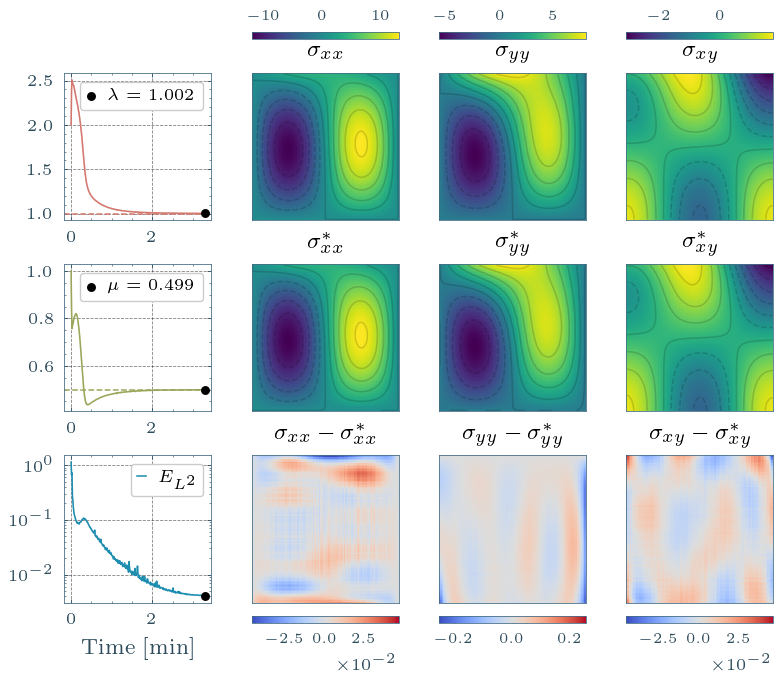

In [8]:
# === Plot single inverse run results ===
run_to_plot = "spinn_mixed_inv"  # Change to plot different configs

if run_to_plot in results_inverse:
    step = len(results_inverse[run_to_plot]["losshistory"].steps) - 2
    
    # Manually create figure with desired size and layout
    fields = ["Sxx", "Syy", "Sxy"]
    show_metrics = True
    show_residual = True
    n_rows = 2 + int(show_residual)
    n_cols = int(show_metrics) + len(fields)
    
    page_width = plt_cfg().page_width
    fig_width = page_width * (n_cols / 4)
    fig_height = fig_width * n_rows / n_cols * 0.97
    fig_inv, ax_inv = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), dpi=200, gridspec_kw={'wspace': 0.1, 'hspace': 0.3})
    
    # Pass custom figure to plot_results
    fig_inv, artists_inv = ap.plot_results(
        results_inverse[run_to_plot], 
        iteration=step, 
        fig=fig_inv, 
        ax=ax_inv,
        step_type="time", 
        time_unit="min", 
        plot_contours=True, 
        fields=fields,
        show_metrics=show_metrics,
        show_residual=show_residual,
    )

    if save_fig:
        figure_folder = "./images"
        os.makedirs(figure_folder+"/pdf", exist_ok=True) 
        figure_name = f"analytical_plate_{run_to_plot}"
        fig_inv.savefig(os.path.join(figure_folder, figure_name + ".png"), bbox_inches='tight', dpi=300)
        fig_inv.savefig(os.path.join(figure_folder, "pdf", figure_name + ".pdf"), bbox_inches='tight')
        print(f"Figure of width {fig_inv.get_size_inches()[0]/plt_cfg().page_width:.2f} x page width saved at {os.path.join(figure_folder, figure_name)}")

else:
    print(f"Run '{run_to_plot}' not found in results_inverse")